In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ast

In [2]:
def design_filter(zeros=None, poles=None, gain=1.0):
    """
    Diseña un filtro digital a partir de ceros y/o polos y una ganancia.

    Parámetros:
    - zeros: lista de ceros (raíces del numerador), o None para no incluir
    - poles: lista de polos (raíces del denominador), o None para no incluir
    - gain: ganancia escalar del filtro

    Devuelve:
    - b: coeficientes del numerador
    - a: coeficientes del denominador
    """
    # Si no se pasan ceros, asumimos un FIR trivial (b = [gain])
    if zeros:
        b = gain * np.poly(zeros)
    else:
        b = np.array([gain], dtype=float)

    # Si no se pasan polos, asumimos sistema FIR (a = [1])
    if poles:
        a = np.poly(poles)
    else:
        a = np.array([1.0], dtype=float)

    return b, a

In [3]:
def gaussian(x, mu, sigma, A):
    """
    Genera una función gaussiana.

    Parámetros:
    - x: array de tiempos
    - mu: posición central de la gaussiana
    - sigma: desviación estándar
    - A: amplitud
    """
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma**2))

In [4]:

def simulate_ecg(duration=10.0, fs=500, heart_rate=60):
    """
    Simula un ECG sintético basado en la superposición de ondas gaussianas.

    Parámetros:
    - duration: duración de la señal en segundos
    - fs: frecuencia de muestreo en Hz
    - heart_rate: frecuencia cardiaca en latidos por minuto

    Devuelve:
    - t: vector de tiempos
    - ecg: señal simulada de ECG en mV
    """
    dt = 1 / fs
    t = np.arange(0, duration, dt)
    rr = 60 / heart_rate  # intervalo RR en segundos

    # Inicializar señal
    ecg = np.zeros_like(t)

    # Parámetros de las ondas (posiciones relativas en segundos)
    # P wave
    p_amp, p_dur, p_delay = 0.25, 0.09, 0.16
    # Q wave
    q_amp, q_dur, q_delay = -0.05, 0.066, 0.166
    # R wave
    r_amp, r_dur, r_delay = 1.6, 0.1, 0.166
    # S wave
    s_amp, s_dur, s_delay = -0.25, 0.066, 0.19
    # T wave
    t_amp, t_dur, t_delay = 0.35, 0.142, 0.36

    # Generar cada latido
    for beat_start in np.arange(0, duration, rr):
        mask = (t >= beat_start) & (t < beat_start + rr)
        tb = t[mask] - beat_start
        ecg[mask] += gaussian(tb, p_delay, p_dur / 2, p_amp)
        ecg[mask] += gaussian(tb, q_delay, q_dur / 2, q_amp)
        ecg[mask] += gaussian(tb, r_delay, r_dur / 2, r_amp)
        ecg[mask] += gaussian(tb, s_delay, s_dur / 2, s_amp)
        ecg[mask] += gaussian(tb, t_delay, t_dur / 2, t_amp)

    return t, ecg+0.1*np.cos(2*np.pi*60*t)

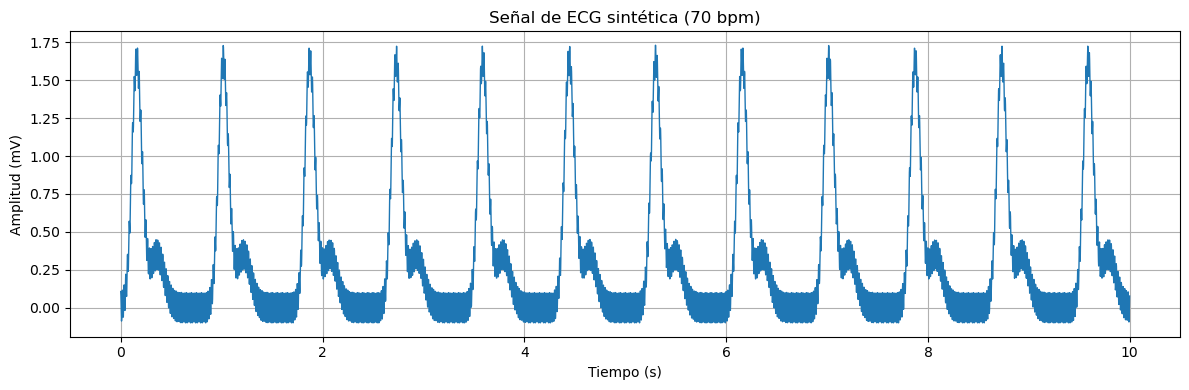

In [5]:
    # Parámetros de simulación
    DURATION = 10    # segundos
    FS = 500         # Hz
    HR = 70          # latidos por minuto

    # Generar señal
    t, ecg_signal = simulate_ecg(duration=DURATION, fs=FS, heart_rate=HR)

    # Graficar resultado
    plt.figure(figsize=(12, 4))
    plt.plot(t, ecg_signal, linewidth=1)
    plt.title(f'Señal de ECG sintética ({HR} bpm)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (mV)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
from scipy import signal

In [7]:
n = len(ecg_signal)
yf = np.fft.rfft(ecg_signal)
xf = np.fft.rfftfreq(n, d=1/FS)
magnitude = np.abs(yf) / n

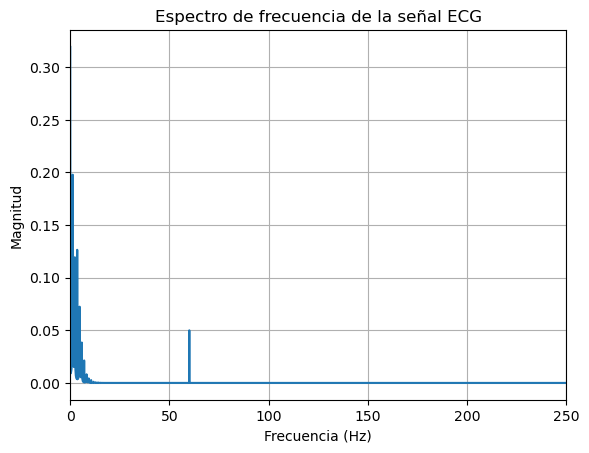

In [8]:
plt.figure()
plt.plot(xf, magnitude)
plt.title("Espectro de frecuencia de la señal ECG")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Magnitud")
plt.xlim(0, FS/2)
plt.grid(True)

In [9]:
b,a = design_filter(zeros=[np.exp(1j*2*np.pi*60/500), np.exp(-1j*2*np.pi*60/500)])
w, h = signal.freqz(b, a, worN=1024)

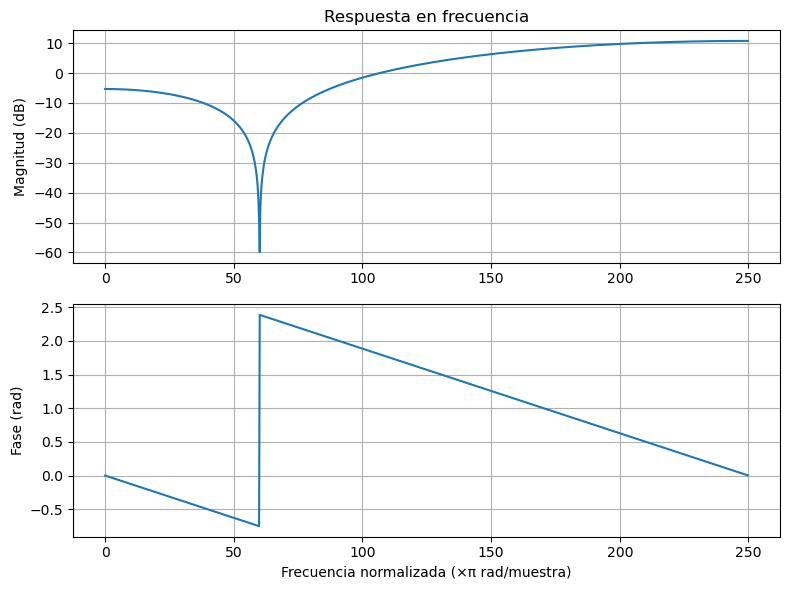

In [10]:
    mag_db = 20 * np.log10(np.abs(h))
    phase = np.unwrap(np.angle(h))

    # Gráficos
    plt.figure(figsize=(8, 6))

    plt.subplot(2, 1, 1)
    plt.plot(250*(w/np.pi), mag_db)
    plt.title("Respuesta en frecuencia")
    plt.ylabel("Magnitud (dB)")
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(250*(w/np.pi), phase)
    plt.xlabel("Frecuencia normalizada (×π rad/muestra)")
    plt.ylabel("Fase (rad)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()